## Motion Retargeting
### The BVH file format
The Biovision Hierarchy (BVH) format stores animation data. It provides the information to construct a character and the pose of this character at each frame of the animation. The character is animated using a skeleton, a hierarchical structure composed of joints. The sense of motion comes from changes on the orientation (and sometimes translation) of these joints.

The BVH file is divided into two sections: the header, identified by the keyword HIERARCHY, and the body, identified by MOTION. The header holds the skeleton hierarchy definition, i.e., the distance between each joint. The body section contains the animation, each line represents one frame in the animation, and it contains the orientation (and translation) at that frame. 

Except for the root joint, the first one in the hierarchy that often represents the hips, every joint has a parent joint. The values stored by the BVH file are relative to the parent joint, in order words, the orientation of a joint in a given frame is the local coordinate system of that joint in respect to its parent joint coordinate system. Furthermore, the orientation at a given frame represents the rotation from the base pose to its current position - and not from the last frame.

### Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

### The Joint and Animation Class
Motion Retargeting process transfer motion between two skeletons. It is defined as the Animation Class to hold the information of each skeleton animation. The most important parameters of an Animation object is the name of the animation and a reference to the root joint of the skeleton.

A Joint object contains a reference to its parent (except for the root), its children and the orientation and translation at each frame. Given the root joint, any joint is reachable recursively.

In [2]:
class Animation:
    def __init__(self, filename, root):
        self.name = filename
        self.root = root
        self.listofjoints = []
        self.surfaceinfo = []
        self.skeletonmap = []
        self.frames = None
        self.frametime = None
    
    def getlistofjoints(self):
        """
        Get list of joints in the animation
        """
        if not self.listofjoints:
            self.listofjoints = self.__auxgetlist(None, [])
        return self.listofjoints
            
    def __auxgetlist(self, joint=None, listofjoints = []):
        """
        Create and return list of joints in the animation
        """
        if not joint:
            joint = self.root
        listofjoints.append(joint)
        for child in joint.children:
            self.__auxgetlist(child, listofjoints)
        if joint == self.root:
            return listofjoints
        
    def getJoint(self, jointname):
        """
        Find the joint with jointname in the animation hierarchy
        """
        return self.root.getByName(jointname)
    
class Joints:
    def __init__(self, name, depth=0, parent=None):
        self.name = name
        self.depth = depth
        self.children = []
        self.parent = parent
        self.endsite = []
        self.translation = []
        self.rotation = []
        self.order = []
        self.length = []
        self.baserotation = []
        if self.parent:
            self.parent.addChild(self)
            
    def __iter__(self):
        for child in self.children:
            yield child
            
    def __reversed__(self):
        while self.parent:
            yield self.parent
            self = self.parent
            
    def addChild(self, item):
        """
        Called after initialization of every joint except root
        """
        item.parent = self
        self.children.append(item)
        
    def addOffset(self, offset):
        self.offset = offset
        
    def addEndSite(self, endsite=None):
        self.endsite = endsite
        self.endsiteposition = []
        
    def getLastDepth(self, depth, jointsInDepth = []):
        """
        Returns the last joint initializated with the depth provided
        """
        if depth==0:
            return self
        else:
            for child in self.children:
                if child.depth == depth:
                    jointsInDepth.append(child)
                child.getLastDepth(depth, jointsInDepth)
            return jointsInDepth[-1]
        
    def getDepth(self):
        depth = 0
        joint = self
        if joint.parent:
            while joint.parent:
                depth = depth + 1
                joint = joint.parent
        return depth
    
    def getByName(self, name):
        """
        Returns the joint object with the provided name
        """
        if self.name == name:
            return self
        for child in self.children:
            if child.name == name:
                return child
            else:
                found = child.getByName(name)
                if found:
                    return found
                
    def printHierarchy(self, hierarchy=[]):
        """
        Print hierarchy
        """
        flag = False
        if len(hierarchy)==0:
            flag = True
        #hierarchy.append(str.format("%s%s %s" % (' '*2*int(self.depth),self.name, self.offset)))
        print("%s%s %s" % (' '*2*int(self.depth),self.name, self.offset))
        try:
            if len(self.endsite)>0:
                #hierarchy.append("%s%s %s" % (' '*2*(int(self.depth+1)),"End Site", self.endsite))
                print("%s%s %s" % (' '*2*(int(self.depth+1)),"End Site", self.endsite))
        except:
            pass
        for child in self.children:
            child.printHierarchy(hierarchy)
        if flag:
            return hierarchy

### Prepare BVH file conversion

In [3]:
def GetBVHDataFromFile(path):  
    
    def GetMotionLine(joint, frame, translation=[], rotation=[]):
        """
        Get rotation and translation data for the joint at the given frame.
        """
        translation.append(frame.split(' ')[len(translation)*6:len(translation)*6+3])
        rotation.append(frame.split(' ')[len(rotation)*6+3:len(rotation)*6+6])
        joint.translation.append(translation[-1])
        joint.rotation.append(rotation[-1])
        for child in joint.children:
            GetMotionLine(child,frame, translation, rotation)
        return translation, rotation
    
    def Motion2NP(joint):
        """
        Transform rotation and position into numpy arrays
        """
        joint.translation = np.asarray(joint.translation, float)
        joint.rotation = np.asarray(joint.rotation, float)
        joint.offset = np.asarray(joint.offset.split(' '),float)
        if joint.order=="ZXY":
            aux = np.copy(joint.rotation[:,0])
            joint.rotation[:,0] = np.copy(joint.rotation[:,1])
            joint.rotation[:,1] = np.copy(joint.rotation[:,2])
            joint.rotation[:,2] = np.copy(aux)
        if joint.endsite:
            joint.endsite = np.asarray(joint.endsite.split(' '),float)
        for child in joint:
            Motion2NP(child)
    
    with open(path) as file:
        data = [line for line in file]
    offsetList = []
    listofjoints = []
    flagEndSite = False
    for line in data:
        if line.find("ROOT") >= 0:
            #Creates root joint
            root = Joints(name = line[5:-1])
            lastJoint = root
            listofjoints.append(line[5:-1])
            #Create the object of this file
            filename = os.path.basename(path)[:-4]
            bvhfile = Animation(filename, root)
        if line.find("JOINT") >= 0:
            depth = line.count('\t')
            if depth == 0:
                depth = line[:line.find('JOINT')].count(' ')/2
            parent = root.getLastDepth(depth-1)
            #Creates joint
            lastJoint = Joints(name = line[line.find("JOINT")+6:-1], depth=depth, parent=parent)
            listofjoints.append(line[line.find("JOINT")+6:-1])
        if line.find("End Site") >= 0:
            flagEndSite = True
            listofjoints.append("End Site")
        if (line.find("OFFSET") >= 0) and (not flagEndSite):
            lastJoint.addOffset(line[line.find("OFFSET")+7:-1])
            offsetList.append(line[line.find("OFFSET")+7:-1])
        elif (line.find("OFFSET") >= 0) and (flagEndSite):
            lastJoint.addEndSite(line[line.find("OFFSET")+7:-1])
            flagEndSite = False
        if (line.find("CHANNELS")) >= 0:
            X = line.find("Xrotation")
            Y = line.find("Yrotation")
            Z = line.find("Zrotation")
            if Z < X and X < Y:
                lastJoint.order = "ZXY"
            elif X < Y and Y < Z:
                lastJoint.order = "XYZ"
            else:
                lastJoint.order("XYZ")
                print("Invalid Channels order. XYZ chosen.")
        if (line.find("MOTION")) >= 0:
            index = data.index('MOTION\n')
            frames = data[index+3:]
            bvhfile.frames = int(data[index+1][8:])
            bvhfile.frametime = float(data[index+2][12:])
            break
    #Go to the next line
    for counter in range(len(frames)):
        GetMotionLine(root, frames[counter], translation=[], rotation=[])
    #Convert values to numpy array
    Motion2NP(bvhfile.root)
    return bvhfile

### Read BVH file

In [8]:
filename = 'RodolfoClaping.bvh'
currentdir = os.getcwd()
datapath = os.path.join(currentdir, '..\sampledata')
fullpath = os.path.join(datapath, filename)
print(fullpath)
animation = GetBVHDataFromFile(fullpath)

C:\Users\Rodolfo\Desktop\IA369\dev\..\sampledata\RodolfoClaping.bvh


Check the animation name and reference to the root joint

In [9]:
print('Animation name: %s. Type: %s' % (animation.name, type(animation)))
print('Animation root: %s. Type: %s' % (animation.root.name, type(animation.root)))
print('Number of joints: %i' % (len(animation.getlistofjoints())))

Animation name: RodolfoClaping. Type: <class '__main__.Animation'>
Animation root: Hips. Type: <class '__main__.Joints'>
Number of joints: 30


Print the name of the joints and their distance from parents recursively

In [10]:
_ = animation.root.printHierarchy()

Hips [ 5.04731 94.866   -7.60916]
  Spine [ 0.      15.3684  -2.40487]
    Spine1 [0.      9.79164 0.     ]
      Spine2 [0.      9.79164 0.     ]
        Spine3 [0.      9.79164 0.     ]
          Neck [ 0.      12.5893   1.25893]
            Neck1 [0.    4.095 0.   ]
              Head [0.    4.095 0.   ]
                End Site [0.      9.72808 0.     ]
          RightShoulder [0.      8.99232 5.27092]
            RightArm [ 0.     21.4762  0.    ]
              RightForeArm [ 0.     30.4806  0.    ]
                RightHand [ 0.     25.7941  0.    ]
                  RightHandThumb1 [-3.10387  3.51294  2.61218]
                    End Site [0. 0. 0.]
                  RightHandMiddle1 [ 0.         9.36783   -0.0600502]
                    End Site [0. 0. 0.]
          LeftShoulder [0.      8.99232 5.27092]
            LeftArm [ 0.     21.4762  0.    ]
              LeftForeArm [ 0.     30.4806  0.    ]
                LeftHand [ 0.     25.7941  0.    ]
                  LeftHandT

### Animation
The only translational joint of the hierarchy is the hips joint, or root, so that the character is able to move accros the volume. All the other joints are usually revolute, slot or spherical joints with 1, 2 and 3 degrees of freedom, respectively.

(-0.9494137433862431, 0.8053762566137577)

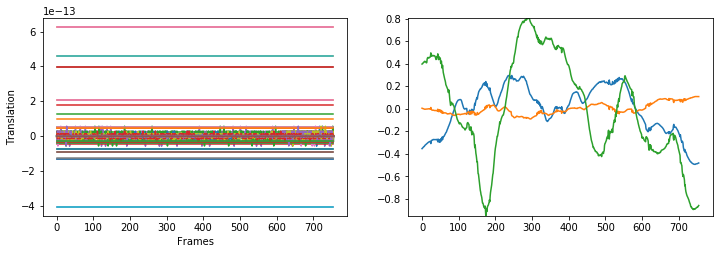

In [11]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(221)
ax1.set_xlabel('Frames')
ax1.set_ylabel('Translation')

for joint in animation.getlistofjoints():
    if joint.name != 'Hips':
        plt.plot(joint.translation - np.mean(joint.translation, axis=0))
        
ax2 = fig.add_subplot(222)
plt.plot(animation.root.translation - np.mean(animation.root.translation, axis=0))

mini,maxi = np.min(animation.root.translation - np.mean(animation.root.translation, axis=0)), np.max(animation.root.translation - np.mean(animation.root.translation, axis=0))

#ax1.set_ylim(mini,maxi)
ax2.set_ylim(mini,maxi)